# Zero dimensional li-s model

In this notebook we solve the model given in Marinescu et al, 2016. 

In [1]:
%pip install pybamm -q

import pybamm
import numpy as np 
import matplotlib.pyplot as plt

You should consider upgrading via the '/home/user/Documents/PyBaMM/env/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We first load the model and update the parameter values to match those given in the paper

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()

# Update current and ICs to correspond to initial 2.4V as in ref [2]
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": 1.7,
        "Initial Condition for S8 ion [g]": 2.6730,
        "Initial Condition for S4 ion [g]": 0.0128,
        "Initial Condition for S2 ion [g]": 4.3321e-6,
        "Initial Condition for S ion [g]": 1.6321e-6,
        "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
        "Initial Condition for Terminal Voltage [V]": 2.4,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
    }
)

We then set up and solve the simulation. There will be some warning where the solver steps into an infeasible region (e.g. where concentration goes negative). These can safely be ignored as the failed steps will be rejected by the solver. 

In [3]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, max_step_decrease_count=10, 
    ),
)
sim.solve(np.linspace(0, 7000, 700))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [4]:
sim.plot(model.variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.8621766761407734, step=0.01862176676140773…

In [5]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  591.931 ms
Final time:  6703.836034106785 s
Termination reason:  event: Zero theoretical capacity


We see that the solver stopped when zero theoretical capacity.

Now we can extract the variables we are interested in from the solution object and plot the results. Let's define a custom plotting function

In [6]:
def my_plot(sim):
    # extract variables 
    t = sim.solution["Time [s]"].entries
    S8 = sim.solution["S8 [g]"].entries
    S4 = sim.solution["S4 [g]"].entries
    S2 = sim.solution["S2 [g]"].entries
    Sp = sim.solution["Precipitated Sulfur [g]"].entries
    S_tot = S8 + S4 + S2 + Sp
    i_H = sim.solution["High plateau current [A]"].entries
    i_L = sim.solution["Low plateau current [A]"].entries
    eta_H = sim.solution["High plateau over-potential [V]"].entries
    eta_L = sim.solution["Low plateau over-potential [V]"].entries
    E_H = sim.solution["High plateau potential [V]"].entries
    E_L = sim.solution["Low plateau potential [V]"].entries
    V = sim.solution["Terminal voltage [V]"].entries

    # set up figure and plot
    fig, ax = plt.subplots(2, 2, figsize=(15,8))

    ax[0, 0].plot(t, S8, label="S8")
    ax[0, 0].plot(t, S4, label="S4")
    ax[0, 0].plot(t, S2, label="S2")
    ax[0, 0].plot(t, Sp, label="Sp")
    ax[0, 0].plot(t, S_tot, label="S_{tot}")
    ax[0, 0].set_xlim([0, 8000])
    ax[0, 0].set_ylim([0, 3])
    ax[0, 0].set_xlabel("Time [s]")
    ax[0, 0].set_ylabel("Species mass [g]")
    ax[0, 0].legend()

    ax[0, 1].plot(t, i_H, label="i_H")
    ax[0, 1].plot(t, i_L, label="i_L")
    ax[0, 1].set_xlim([0, 8000])
    ax[0, 1].set_ylim([0, 2])
    ax[0, 1].set_xlabel("Time [s]")
    ax[0, 1].set_ylabel("Reaction current [A]")
    ax[0, 1].legend()

    ax[1, 0].plot(t, eta_H, label="eta_H")
    ax[1, 0].plot(t, eta_L, label="eta_L")
    ax[1, 0].set_xlim([0, 8000])
    ax[1, 0].set_ylim([-20e-3, 0])
    ax[1, 0].set_xlabel("Time [s]")
    ax[1, 0].set_ylabel("Reaction overpotential [V]")
    ax[1, 0].legend()

    ax[1, 1].plot(t, E_H, label="E_H")
    ax[1, 1].plot(t, E_L, label="E_L")
    ax[1, 1].plot(t, V, label="V")
    ax[1, 1].set_xlim([0, 8000])
    ax[1, 1].set_ylim([2.2, 2.45])
    ax[1, 1].set_xlabel("Time [s]")
    ax[1, 1].set_ylabel("Nernst and cell voltages [V]")
    ax[1, 1].legend()

and create the plot

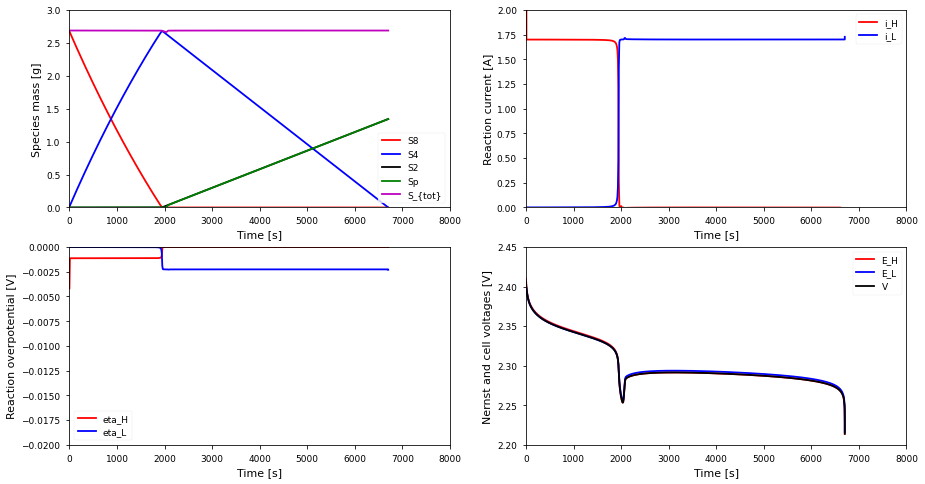

In [7]:
my_plot(sim)

## References

The relevant papers for this notebook are:

In [8]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Monica Marinescu, Laura O’Neill, Teng Zhang, Sylwia Walus, Timothy E Wilson, and Gregory J Offer. Irreversible vs reversible capacity fade of lithium-sulfur batteries during cycling: the effects of precipitation and shuttle. Journal of The Electrochemical Society, 165(1):6107–6118, 2018.
[4] Monica Marinescu, Teng Zhang, and Gregory J Offer. A zero dimensional model of lithium–sulfur batteries during charge and discharge. Physical Chemistry Chemical Physi